In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from optiver import Directories
from optiver.utils import realized_volatility, generate_dfs
from optiver.bench import rmspe

dirs = Directories("../..")

In [2]:
def aggs(series, name: str):
    series = series.groupby(level="time_id")
    
    mean = series.mean()
    std = series.std()
    minimum = series.min()
    median = series.median()
    maximum = series.max()
    
    return pd.DataFrame({f"{name}_mean": mean, f"{name}_std": std, f"{name}_min": minimum, f"{name}_med": median, f"{name}_max": maximum})


def wap1(df):
    return wap(df["bid_price1"], df["bid_size1"], df["ask_price1"], df["ask_size1"])


def wap2(df):
    return wap(df["bid_price2"], df["bid_size2"], df["ask_price2"], df["ask_size2"])


def wap(bid_price, bid_size, ask_price, ask_size):
    return (bid_price * ask_size + ask_price * bid_size) / (bid_size + ask_size)


def bid_ask_spread(df):
    return df["ask_price1"] / df["bid_price1"] - 1


def preprocess_df(df):
    past_vol_df = pd.DataFrame({"past_vol": realized_volatility(df)})
    wap1_df = aggs(wap1(df), "wap1")
    wap2_df = aggs(wap2(df), "wap2")
    bid_ask_df = aggs(bid_ask_spread(df), "spread")
    
    return pd.concat([past_vol_df, wap1_df, wap2_df, bid_ask_df], axis=1)

In [3]:
# feature_df = pd.concat({stock_id:preprocess_df(df) for stock_id, df, in tqdm(generate_dfs(dirs.processed / "book_train"), total=92)}, names=("stock_id", "time_id"))

In [4]:
# feature_df

In [5]:
# feature_df.to_hdf(dirs.processed / "book_features.h5", key="book_features")

In [3]:
feature_df = pd.read_hdf(dirs.processed / "book_features.h5")
targets = pd.read_hdf(dirs.processed / "targets_train.h5")

In [7]:
len(feature_df), len(targets)

(281874, 281874)

In [4]:
targets_val = targets.sample(frac=0.2, random_state=0).sort_index()
val_index = targets_val.index

targets_train = targets.drop(val_index)

feature_train, feature_val = feature_df.drop(val_index).sort_index(), feature_df.loc[val_index]

In [9]:
display(feature_train)
targets_train

past_vol  wap1_mean  wap1_std  wap1_min  wap1_med  wap1_max  \
stock_id time_id                                                                
0        5        0.004499   1.003725  0.000693  1.001434  1.003923  1.004920   
         11       0.001204   1.000239  0.000262  0.999700  1.000232  1.000834   
         16       0.002369   0.999542  0.000864  0.997224  0.999818  1.000878   
         31       0.002574   0.998832  0.000757  0.997447  0.998657  1.000412   
         62       0.001894   0.999619  0.000258  0.999231  0.999586  1.000159   
...                    ...        ...       ...       ...       ...       ...   
126      32746    0.018288   0.988887  0.003884  0.983396  0.987994  1.001520   
         32748    0.003812   0.999423  0.001428  0.996570  1.000039  1.001107   
         32750    0.003293   1.000025  0.000971  0.998281  0.999979  1.002136   
         32751    0.003691   0.999582  0.000486  0.998250  0.999611  1.000736   
         32767    0.002092   1.000272  0.000384  0.999178  1.000314  1.001058   

                  wap2_mean  wap2_std  wap2_min  wap2_med  wap2_max  \
stock_id time_id                                                      
0        5         1.003661  0.000781  1.001390  1.003821  1.005124   
         11        1.000206  0.000272  0.999575  1.000192  1.001067   
         16        0.999680  0.000862  0.996897  0.999751  1.000876   
         31        0.998633  0.000656  0.997430  0.998573  1.000116   
         62        0.999626  0.000317  0.999102  0.999598  1.000249   
...                     ...       ...       ...       ...       ...   
126      32746     0.989170  0.003909  0.982830  0.988464  1.000199   
         32748     0.999443  0.001486  0.996525  0.999961  1.001356   
         32750     0.999987  0.001037  0.998192  0.999978  1.002215   
         32751     0.999585  0.000613  0.997950  0.999506  1.000788   
         32767     1.000367  0.000465  0.999129  1.000457  1.001306   

                  spread_mean  spread_std  spread_min  spread_med  spread_max  
stock_id time_id                                                               
0        5           0.000852    0.000212    0.000361    0.000876    0.001394  
         11          0.000394    0.000157    0.000151    0.000351    0.000904  
         16          0.000725    0.000164    0.000384    0.000718    0.001150  
         31          0.000861    0.000280    0.000324    0.000788    0.001624  
         62          0.000397    0.000130    0.000093    0.000373    0.000793  
...                       ...         ...         ...         ...         ...  
126      32746       0.004404    0.001877    0.001505    0.004151    0.008905  
         32748       0.000629    0.000193    0.000052    0.000620    0.001138  
         32750       0.000774    0.000214    0.000206    0.000786    0.001200  
         32751       0.000878    0.000235    0.000392    0.000882    0.001570  
         32767       0.000432    0.000125    0.000154    0.000412    0.000823  

[225499 rows x 16 columns]

stock_id  time_id
0         5          0.004136
          11         0.001445
          16         0.002168
          31         0.002195
          62         0.001747
                       ...   
126       32746      0.009973
          32748      0.003776
          32750      0.003350
          32751      0.003461
          32767      0.002090
Name: target, Length: 225499, dtype: float64

In [10]:
def select_means(df):
    return df[["past_vol", "wap1_mean", "wap2_mean", "spread_mean"]]


means_train = select_means(feature_train)
means_val = select_means(feature_val)

In [5]:
def knn_predict(input_df, train_features, train_labels, k=1):
    inp = input_df.to_numpy()
    features = train_features.to_numpy()
    labels = train_labels.to_numpy()
    
    diffs = inp[:, :, None] - features.T[None, :, :]
    
    distances = np.sum(diffs**2, axis=1)**(0.5)
    
    sort_indices = np.argsort(distances, axis=1)[:, :k]
    
    predictions = labels[sort_indices].mean(axis=1)
    
    return pd.Series(predictions, index=input_df.index)


def knn_predict_all(input_df, train_feature_df, k=1):
    stock_ids = set(targets_train.index.get_level_values("stock_id"))
    
    return ((stock_id, knn_predict(input_df.loc[stock_id], train_feature_df.loc[stock_id], targets_train.loc[stock_id], k=k)) for stock_id in stock_ids)


def try_ks(ks, input_df, train_feature_df):
    results = []
    
    for k in tqdm(ks):
        predictions = pd.concat({stock_id: df for stock_id, df in knn_predict_all(input_df, train_feature_df, k=k)}, names=("stock_id", "time_id"))
        results.append(rmspe(predictions, targets_val))
    
    return results

In [ ]:
trials = [1] + list(range(10, 201, 10))

rmspes = try_ks(trials, feature_val, feature_train)

In [ ]:
trial_data = pd.DataFrame({"k": trials, "rmspe": rmspes})

# trial_data.plot(x="k", y="rmspe")
# trial_data

In [ ]:
spec_trials = list(range(10, 30, 2))

spec_rmspes = try_ks(spec_trials, feature_val, feature_train)

Best RMSPE with raw aggregations is 31.48%.

In [ ]:
spec_data = pd.DataFrame({"k": spec_trials, "rmspe": spec_rmspes})

display(spec_data)

spec_data.plot(x="k", y="rmspe")

In [12]:
def normalize(df):
    return (df - df.mean()) / df.std()

normal_feature_train, normal_feature_val = normalize(feature_train), normalize(feature_val)

In [ ]:
normal_trials = list(range(10, 30, 2))

normal_rmspes = try_ks(normal_trials, normal_feature_val, normal_feature_train)

In [ ]:
normal_data = pd.DataFrame({"k": normal_trials, "rmspe": normal_rmspes})

display(normal_data)

normal_data.plot(x="k", y="rmspe")

In [139]:
pca_vals, pca_vecs = np.linalg.eig(normal_feature_train.cov())
sort_indices = np.flip(np.argsort(pca_vals))

np.sum(pca_vals[sort_indices][:6]) / np.sum(pca_vals)

components = pca_vecs[:, sort_indices[:6]]

In [ ]:
pca_train, pca_val = normal_feature_train.dot(components), normal_feature_val.dot(components)

pca_train

In [145]:
pca_trials = list(range(10, 201, 10))

pca_rmspes = try_ks(pca_trials, pca_val, pca_train)

100%|████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]


In [15]:
def display_plot(trials, rmspes):
    data = pd.DataFrame({"k": trials, "rmspe": rmspes})

    display(data)

    data.plot(x="k", y="rmspe")
    

def display_plot_trials(train_df, val_df, start=10, stop=30, step=2):
    trials = list(range(start, stop, step))
    rmspes = try_ks(trials, val_df, train_df)
    
    display_plot(trials, rmspes)

Normalizing data seems to have made performance worse.

In [ ]:
display_plot(pca_trials, pca_rmspes)

In [176]:
centered_train, centered_val = feature_train - feature_train.mean(), feature_val - feature_val.mean()

pca_vals, pca_vecs = np.linalg.eig(centered_train.cov())
sort_indices = np.flip(np.argsort(pca_vals))

np.sum(pca_vals[sort_indices][:2]) / np.sum(pca_vals)

components = pca_vecs[:, sort_indices[:4]]

In [177]:
pca_train, pca_val = centered_train.dot(components), centered_val.dot(components)

pca_train

0         1         2         3
stock_id time_id                                        
0        5       -0.009901  0.000505  0.001002  0.000594
         11      -0.000753  0.004607  0.000297 -0.000122
         16       0.001860  0.001838 -0.000550  0.001069
         31       0.003498  0.002346  0.000455 -0.000199
         62       0.000974  0.004416  0.000800 -0.000090
...                    ...       ...       ...       ...
126      32746    0.027761 -0.021023  0.003547 -0.004193
         32748    0.001959  0.000175 -0.000540  0.001305
         32750   -0.000268  0.001099 -0.000106 -0.000315
         32751    0.001406  0.001801  0.001261  0.000215
         32767   -0.000761  0.003522  0.000291  0.000248

[225499 rows x 4 columns]

Not really much headway with Principal Components Analysis.

100%|██████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.81s/it]


,k,rmspe
0,10,0.327411
1,12,0.324153
2,14,0.322613
3,16,0.321960
4,18,0.321837


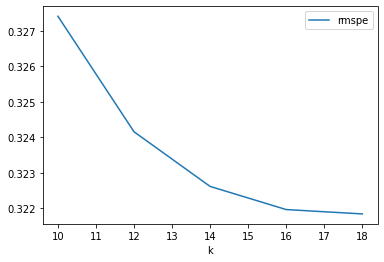

In [179]:
display_plot_trials(pca_train, pca_val, start=10, stop=20, step=2)

In [29]:
def preprocess_intervals(df):
    def preprocess_interval(interval_df, t):
        wap1_df = aggs(wap1(interval_df), f"wap1_t{t}")
        wap2_df = aggs(wap2(interval_df), f"wap2_t{t}")
        spread_df = aggs(bid_ask_spread(interval_df), f"spread_t{t}")
        
        return pd.concat([wap1_df, wap2_df, spread_df], axis=1)
        
    dfs = []
    for t in range(0, 591, 10):
        interval_df = df.loc[(slice(None), slice(t, t + 10)), :]
        dfs.append(preprocess_interval(interval_df, t))
    
    return pd.concat(dfs, axis=1)

In [30]:
interval_df = pd.concat({stock_id:preprocess_intervals(df).fillna(value=0.) for stock_id, df, in tqdm(generate_dfs(dirs.processed / "book_train"), total=92)}, names=("stock_id", "time_id"))

100%|████████████████████████████████████████████████████████████| 92/92 [05:02<00:00,  3.29s/it]


In [64]:
interval_df.to_hdf(dirs.processed / "book_features_interval10.h5", "book_features_interval10")

In [65]:
interval_train, interval_val = interval_df.drop(targets_val.index).sort_index(), interval_df.loc[targets_val.index].sort_index()

In [41]:
centered_train, centered_val = interval_train - interval_train.mean(), interval_val - interval_val.mean()

pca_vals, pca_vecs = np.linalg.eig(centered_train.cov())
sort_indices = np.flip(np.argsort(pca_vals))

component_count = 55

print(np.sum(pca_vals[sort_indices][:component_count]) / np.sum(pca_vals))

components = pca_vecs[:, sort_indices[:component_count]]

pca_train, pca_val = centered_train.dot(components), centered_val.dot(components)

pca_train

0.9542677522346837


0         1         2         3         4         5   \
stock_id time_id                                                               
0        5       -0.096588 -0.290452  0.218022  0.105357  0.656793 -0.144849   
         11      -1.373615 -0.949233 -0.695630 -0.812228  0.608523  0.066630   
         16      -1.290936 -1.067093 -0.467036  1.954101 -1.721481 -0.863650   
         31      -4.273390  0.519926  1.687656  0.626621 -1.398454  1.365902   
         62      -2.434948  1.609688 -0.699200 -0.141744 -0.243645  1.206555   
...                    ...       ...       ...       ...       ...       ...   
126      32746   -0.061609 -0.206180 -0.279981 -0.258348  0.259222 -0.224102   
         32748    0.434172  0.029368 -0.018770 -0.016894  0.005718 -0.008193   
         32750    0.089064 -0.120888  0.653115 -0.408019  0.018449  0.516998   
         32751    0.097499 -0.131867  0.572475 -0.074867  0.264175  0.580781   
         32767   -0.884217 -0.653051  1.281432 -0.300021  0.678991  0.464692   

                        6         7         8         9   ...        45  \
stock_id time_id                                          ...             
0        5        0.319466  0.932595 -0.241862 -0.267893  ... -0.110135   
         11      -1.382623  1.309694 -0.680998  1.349218  ...  1.486887   
         16      -1.146413 -0.049707  1.048721 -1.219565  ... -0.202318   
         31       0.102208 -1.273975 -2.739704 -1.497113  ... -0.290821   
         62      -0.949177 -0.289681 -1.358823  0.866835  ... -1.873622   
...                    ...       ...       ...       ...  ...       ...   
126      32746   -0.181830  0.168184 -0.081794  0.140286  ...  0.224057   
         32748    0.001335  0.000695  0.002409  0.004134  ...  0.001370   
         32750   -0.686644 -0.584556 -0.248646 -0.218216  ... -0.046077   
         32751   -0.339697 -0.013199  0.610327  0.450298  ... -0.191385   
         32767   -1.244080 -1.324262 -0.554254  0.853480  ...  0.523390   

                        46        47        48        49        50        51  \
stock_id time_id                                                               
0        5       -0.390377  0.175708 -0.294197  0.732316 -0.433027 -0.159177   
         11      -1.573538  0.598743 -0.537845  0.176025 -0.760428 -0.339428   
         16      -0.305945 -0.434232 -1.301045  0.071099  0.690117  0.124860   
         31       0.215042 -0.365900  0.009709  0.386129 -0.593462 -0.459740   
         62      -0.015408 -0.096845 -0.356263  1.826739 -0.713772  0.487448   
...                    ...       ...       ...       ...       ...       ...   
126      32746    0.205153 -0.129332 -0.260695 -0.277947 -0.130298  0.603412   
         32748    0.001040  0.001058 -0.000377  0.001196  0.001416 -0.000366   
         32750   -0.117097  0.073976  0.161240  0.515542  0.006105 -0.183508   
         32751    0.452303 -0.118618 -0.286848  0.007974  0.012035  0.005196   
         32767    0.670179  0.370300  0.424890 -0.069708 -0.176788 -0.324034   

                        52        53        54  
stock_id time_id                                
0        5        0.675778 -0.694554  0.032275  
         11      -0.443374 -1.338834  1.503165  
         16      -0.179077 -0.330409  0.141362  
         31       0.335321  0.145853 -0.007189  
         62      -0.826909  1.122755  0.630479  
...                    ...       ...       ...  
126      32746    0.971890  0.508332 -0.746586  
         32748    0.000390 -0.000454 -0.000686  
         32750    0.159355 -0.046348 -0.029222  
         32751   -0.056370  0.020501  0.009908  
         32767    1.222182 -0.467145 -0.093522  

[225499 rows x 55 columns]

100%|██████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.17s/it]


,k,rmspe
0,5,0.811699


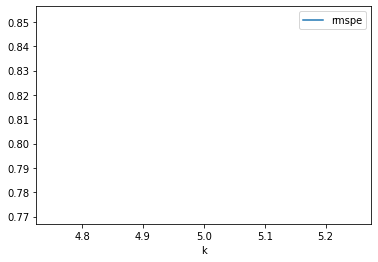

In [44]:
display_plot_trials(pca_train, pca_val, start=5, stop=6, step=1)

In [61]:
def do_pca(train_df, val_df, component_count=1):
    centered_train, centered_val = train_df - train_df.mean(), val_df - val_df.mean()

    pca_vals, pca_vecs = np.linalg.eig(centered_train.cov())
    sort_indices = np.flip(np.argsort(pca_vals))

    print(np.sum(pca_vals[sort_indices][:component_count]) / np.sum(pca_vals))

    components = pca_vecs[:, sort_indices[:component_count]]

    return centered_train.dot(components), centered_val.dot(components)

In [72]:
interval_pca_train, interval_pca_val = do_pca(interval_train, interval_val, component_count=1)

0.09770082960616197


In [8]:
# interval_pca_train["past_vol"] = feature_train["past_vol"]
# interval_pca_val["past_vol"] = feature_val["past_vol"]

interval_pca_train = pd.DataFrame({"past_vol": feature_train["past_vol"]})
interval_pca_val = pd.DataFrame({"past_vol": feature_val["past_vol"]})

In [33]:
stock_id = 110

preds = knn_predict(interval_pca_train.loc[stock_id], interval_pca_train.loc[stock_id], targets_train.loc[stock_id], k=2)
# preds = knn_predict_all(interval_pca_val, interval_pca_train, k=110)

rmspe(preds, targets_train.loc[stock_id])

0.2599866580825194

100%|██████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.48s/it]


,k,rmspe
0,108,0.302766
1,109,0.302665
2,110,0.302511
3,111,0.302670


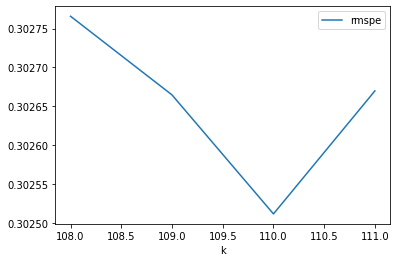

In [20]:
display_plot_trials(interval_pca_train, interval_pca_val, start=108, stop=112, step=1)

Best RMSPE so far is 30.25% using only past volatility as a predictor and KNN with k=110

In [86]:
interval_pca_train["target"] = targets_train

<AxesSubplot:xlabel='past_vol', ylabel='target'>

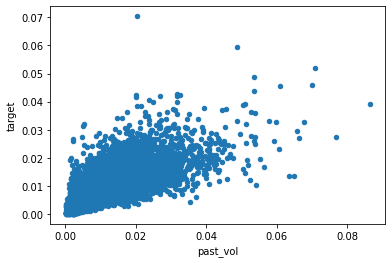

In [106]:
interval_pca_train.plot(x="past_vol", y="target", kind="scatter")